In [ ]:
%%capture
# Skip restarting message in Colab
import sys; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None

# !pip install git+https://github.com/nmecklenburg/unsloth.git#egg=package-name[colab-new]
!pip install unsloth vllm
!pip install --upgrade pillow

# SFT

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Phi-4",
    model_name="unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["gate_proj", "up_proj", "down_proj",],
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-13 03:33:00 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 24.67 G

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-13 03:33:18 model_runner.py:1115] Loading model weights took 2.1371 GB
INFO 03-13 03:33:18 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 03:33:21 worker.py:267] Memory profiling takes 2.63 seconds
INFO 03-13 03:33:21 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 03-13 03:33:21 worker.py:267] model weights take 2.14GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.39GiB; the rest of the memory reserved for KV Cache is 24.76GiB.
INFO 03-13 03:33:21 executor_base.py:111] # cuda blocks: 4225, # CPU blocks: 1024
INFO 03-13 03:33:21 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 33.01x
INFO 03-13 03:33:26 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:56<00:00,  1.31s/it]

INFO 03-13 03:34:22 model_runner.py:1562] Graph capturing finished in 56 secs, took 1.09 GiB
INFO 03-13 03:34:22 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 64.28 seconds



Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


In [ ]:
from datasets import load_from_disk
from google.colab import drive

drive.mount('/content/drive')
sft_train = load_from_disk("/content/drive/MyDrive/cs234/sft_train_20k")
counts = {}
for ex in sft_train:
  counts[ex['task_type']] = counts.get(ex['task_type'], 0) + 1
print(counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'verifiable_math': 14576, 'verifiable_code': 1432, 'code_output_prediction': 1762, 'llm_judgeable_groundtruth_similarity': 2230}


In [ ]:
from trl import apply_chat_template

import re

def transform_convo(row):
    user, assistant = row['messages']
    user['content'] = user['content'].replace("\nReturn your final response as 'Final Answer: \\boxed{<answer>}', where <answer> is the number or mathematical expression of the solution.", "")
    try:
        cot, answer = re.match(r".*(<think>.*?</think>).*\\boxed\{(.*)\}[^{]*", assistant['content'], re.S).groups()
        assistant['content'] = cot + f'\n\n<answer>{answer}</answer>'
    except AttributeError:
        return {"messages": None}
    return {"messages": [user, assistant]}


transformed_reasoning_general_train = sft_train.map(transform_convo, num_proc=10, remove_columns=sft_train.features)\
                                               .filter(lambda example: example['messages'] is not None)\
                                               .map(apply_chat_template,
                                                    fn_kwargs={"tokenizer": tokenizer},
                                                    num_proc=10,
                                                    remove_columns=['messages'])

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/14568 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset, concatenate_datasets

market_sizing_train = load_dataset("json", data_files="/content/drive/MyDrive/cs234/synthesized_market_sizing_sft_data.jsonl")
processed_market_sizing_train = market_sizing_train['train'].map(apply_chat_template,
                                                                 fn_kwargs={"tokenizer": tokenizer},
                                                                 num_proc=10,
                                                                 remove_columns=['messages'])

processed_sft_train = concatenate_datasets([transformed_reasoning_general_train, processed_market_sizing_train]).shuffle(712)

In [ ]:
processed_sft_train[0]

{'text': '<|user|>\nHow does the market size for high-end luggage compare to budget luggage in North America?\n<|end|>\n<|assistant|>\n<think>\nAssume that in North America most households replace luggage every several years and that overall unit volume is similar across all products. The high‐end segment tends to be a niche: only a small fraction of buyers choose premium brands. For example, assume that about 10% of luggage purchases are in the high‐end segment while the remaining 90% are budget purchases. With high‐end pieces averaging roughly four times the price of their budget counterparts (say, $600 versus $150), even a small volume share yields substantial dollars. Under these assumptions the annual revenue from high‐end sales would be:\n\u2003\u20030.10 × (number of units) × 600,\nand from budget sales:\n\u2003\u20030.90 × (number of units) × 150.\nThe ratio is:\n\u2003\u2003[0.10×600] / [0.90×150] = 60/135 ≈ 0.44.\nRounding a bit to account for estimation uncertainty, the high

In [ ]:
processed_sft_train[1]

{'text': "<|user|>\nA rectangular slice of bread with an area of 59.6 square centimeters (cm2) is divided into 4 equal parts. What is the area of one part?\n<|end|>\n<|assistant|>\n<think>Alright, so I need to find the area of one part when a rectangular slice of bread with an area of 59.6 cm² is divided into 4 equal parts. Hmm, okay. Let me think through this step by step.\n\nFirst, the problem says the bread is rectangular, but the exact dimensions aren't given. However, the total area is provided, which is 59.6 cm². When something is divided into equal parts, especially when it's area we're talking about, each part should have an equal area. So, if the total area is divided by the number of parts, that should give me the area of each individual part, right?\n\nSo, if there are 4 equal parts, each part's area would be the total area divided by 4. Let me write that down. The formula would be:\n\nArea of one part = Total area / Number of parts\n\nPlugging in the numbers:\n\nArea of one

In [ ]:
from trl import SFTConfig, SFTTrainer

train_config = SFTConfig(
    bf16=is_bfloat16_supported(),      # True
    fp16=not is_bfloat16_supported(),  # False
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    log_level="info",
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit",
    num_train_epochs=1,
    max_steps=-1,
    output_dir="./checkpoint_dir",
    overwrite_output_dir=True,
    remove_unused_columns=True,
    save_steps=10000,
    save_total_limit=1,
    seed=712,
    warmup_ratio=0.2,
    dataset_text_field="text",
    packing=True,
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=train_config,
    train_dataset=processed_sft_train,
)

trainer.train()

Tokenizing to ["text"] (num_proc=12):   0%|          | 0/24568 [00:00<?, ? examples/s]

Packing train dataset (num_proc=12):   0%|          | 0/24568 [00:00<?, ? examples/s]

Using auto half precision backend
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 15,925 | Num Epochs = 1 | Total steps = 1,991
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 69,206,016/2,078,346,240 (3.33% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.419400
2,1.333000
3,1.408300
4,1.413900
5,1.452800
6,1.233800
7,1.408900
8,1.312600
9,1.401600
10,1.298000


Saving model checkpoint to ./checkpoint_dir/checkpoint-1991
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--phi-3.5-mini-instruct-bnb-4bit/snapshots/9274d79d2f899c2b719ce874f7ee3bfc4a8a2b24/config.json
Model config LlamaConfig {
  "_name_or_path": "unsloth/Phi-3.5-mini-instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "head_dim": 96,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32000,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4b

TrainOutput(global_step=1991, training_loss=0.785498324169818, metrics={'train_runtime': 2751.1739, 'train_samples_per_second': 5.788, 'train_steps_per_second': 0.724, 'total_flos': 1.937144321409024e+17, 'train_loss': 0.785498324169818})

In [ ]:
# import shutil

# shutil.copytree("./checkpoint_dir", "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/augmented-sft-phi-3.5-mini-instruct/")

'/content/drive/MyDrive/cs234/unsloth_sft_ckpts/augmented-sft-phi-3.5-mini-instruct/'

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct") # Local saving

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--phi-3.5-mini-instruct-bnb-4bit/snapshots/9274d79d2f899c2b719ce874f7ee3bfc4a8a2b24/config.json
Model config LlamaConfig {
  "_name_or_path": "unsloth/Phi-3.5-mini-instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "head_dim": 96,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32000,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4"

# SFT Eval

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Phi-4",
    model_name="/content/drive/MyDrive/cs234/unsloth_sft_ckpts/augmented-sft-phi-3.5-mini-instruct/checkpoint-1991",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

FastLanguageModel.for_inference(model)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-13 08:54:17 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 24.67 G

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-13 08:54:35 model_runner.py:1115] Loading model weights took 2.1371 GB
INFO 03-13 08:54:35 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 08:54:38 worker.py:267] Memory profiling takes 2.61 seconds
INFO 03-13 08:54:38 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 03-13 08:54:38 worker.py:267] model weights take 2.14GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.39GiB; the rest of the memory reserved for KV Cache is 24.76GiB.
INFO 03-13 08:54:38 executor_base.py:111] # cuda blocks: 4225, # CPU blocks: 1024
INFO 03-13 08:54:38 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 33.01x
INFO 03-13 08:54:43 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]

INFO 03-13 08:55:41 model_runner.py:1562] Graph capturing finished in 59 secs, took 1.09 GiB
INFO 03-13 08:55:41 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 66.58 seconds



Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (k_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (v_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=3072, out_features=8192, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
              

In [ ]:
text = tokenizer.apply_chat_template([
    # {"role" : "system", "content" : "You are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \\boxed{{1.0}}. We will interpret your answer as being in dollars."},
    {"role": "user", "content": "What is the total market size for commercial lithographic printing in the US?"},
], tokenize = False)

text += "\n<|assistant|>\n<think>"
text = text.replace('\n<|endoftext|>', '')

print(text)

input_ids = tokenizer.encode(text, return_tensors='pt').to("cuda")
print(type(input_ids))
print(input_ids)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=1024, pad_token_id=tokenizer.eos_token_id)

<|user|>
What is the total market size for commercial lithographic printing in the US?<|end|>
<|assistant|>
<think>
<class 'torch.Tensor'>
tensor([[32010,  1724,   338,   278,  3001,  9999,  2159,   363, 12128,   301,
           389, 12122, 14010,   297,   278,  3148, 29973, 32007, 32001,   529,
           386,   682, 29958]], device='cuda:0')

We begin by noting that “commercial lithographic printing” in the US is a niche segment of the overall printing market. Although there is no single published figure for this specific segment, we can use a back‐of‐the‐envelope approach. For example, if we assume that the overall US printing market is on the order of 100 billion in annual revenue and that lithography represents roughly 1% of that (given its specialized nature), then the total market size for commercial lithographic printing would be about 1 billion. This is a rough estimate based on available market segmentation data.
</think>
<answer>1000000000</answer><|end|><|endoftext|>


'<|system|>\nYou are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \\boxed{{1.0}}. We will interpret your answer as being in dollars.<|end|>\n<|user|>\nWhat is the total market size for commercial lithographic printing in the US?<|end|>\n<|assistant|>\n<think>'

False

# GRPO

In [ ]:
from google.colab import drive

import pandas as pd

drive.mount('/content/drive')
raw_rl_data = pd.read_excel("/content/drive/MyDrive/cs234/market_stats.xlsx", usecols="A:D")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported

max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/augmented-sft-phi-3.5-mini-instruct/checkpoint-1991",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-13 15:07:47 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 24.67 G

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-13 15:08:04 model_runner.py:1115] Loading model weights took 2.1371 GB
INFO 03-13 15:08:04 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 15:08:07 worker.py:267] Memory profiling takes 2.67 seconds
INFO 03-13 15:08:07 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 03-13 15:08:07 worker.py:267] model weights take 2.14GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.39GiB; the rest of the memory reserved for KV Cache is 24.76GiB.
INFO 03-13 15:08:08 executor_base.py:111] # cuda blocks: 4225, # CPU blocks: 1024
INFO 03-13 15:08:08 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 33.01x
INFO 03-13 15:08:12 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]

INFO 03-13 15:09:10 model_runner.py:1562] Graph capturing finished in 58 secs, took 1.09 GiB
INFO 03-13 15:09:10 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 65.66 seconds



Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


In [ ]:
#############################################################################
# interestingly, unsloth does some hacks that seems to break RL training on #
# top of a SFT checkpoint. here we outhack their hacks to do a lot of the   #
# same antipattern overwrites and piping that makes their training libs     #
# work, while skipping the peft/patch overrides that seems to be impacting  #
# performance.                                                              #
#############################################################################
import unsloth
import os, gc, functools, types
from transformers import set_seed as transformers_set_seed
from unsloth.models._utils import patch_unsloth_smart_gradient_checkpointing, offload_input_embeddings, offload_output_embeddings, __version__
from unsloth.models.llama import unsloth_fast_generate, FastLlamaModel
from peft import PeftModelForCausalLM, TaskType, LoraConfig, get_peft_model as _get_peft_model
import inspect
import torch
from transformers.models.llama.modeling_llama import logger


def get_peft_model(
    model,
    r                   = 16,
    target_modules      = ["q_proj", "k_proj", "v_proj", "o_proj",
                       "gate_proj", "up_proj", "down_proj"],
    lora_alpha          = 16,
    lora_dropout        = 0,
    bias                = "none",
    layers_to_transform = None,
    layers_pattern      = None,
    use_gradient_checkpointing = True,
    random_state        = 3407,
    max_seq_length      = 2048, # not used anymore
    use_rslora          = False,
    modules_to_save     = None,
    init_lora_weights   = True,
    loftq_config        = {},
    temporary_location  = "_unsloth_temporary_saved_buffers",
    lora_path           = None,
    **kwargs,
):
    if os.environ.get("UNSLOTH_ENABLE_FULL_FINETUNING", "0") == "1":
        print("Unsloth: Full finetuning is enabled, so .get_peft_model has no effect")
        return model
    pass
    transformers_set_seed(random_state)
    if use_gradient_checkpointing == "unsloth":
        patch_unsloth_smart_gradient_checkpointing(dtype = model.get_input_embeddings().weight.dtype)

    if loftq_config is None: loftq_config = {}
    signature = str(inspect.signature(LoraConfig))
    SUPPORTS_LOFTQ  = "loftq_config" in signature
    SUPPORTS_RSLORA = "use_rslora"   in signature
    if lora_dropout != 0:
        logger.warning_once(
            f"Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = {lora_dropout}.\n"\
            f"Unsloth will patch all other layers, except LoRA matrices, causing a performance hit."
        )
    pass
    if bias != "none":
        logger.warning_once(
            f"Unsloth: bias = `none` is supported for fast patching. You are using bias = {bias}.\n"\
            f"Unsloth will patch all other layers, except LoRA matrices, causing a performance hit."
        )
    pass
    if not (type(init_lora_weights) is bool or \
        init_lora_weights == "gaussian" or init_lora_weights == "loftq"):
        raise ValueError(
            'Unsloth: `init_lora_weights` must be either [True, False, "gaussian", "loftq"].'
        )
    pass
    if init_lora_weights == "loftq":
        if not SUPPORTS_LOFTQ:
            import peft
            raise RuntimeError(
                f"Unsloth: Your PEFT version of {peft.__version__} does not support LoftQ init.\n"\
                "Please install PEFT 0.7.2 or higher.\n"\
                "You can also install from source: `pip install git+https://github.com/huggingface/peft.git"
            )
        pass
        if loftq_config == {}:
            from peft import LoftQConfig
            logger.warning_once(
                "Unsloth: init_lora_weights = `loftq` is set, but `loftq_config` is None.\n"\
                "We shall use `loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1)`."
            )
            loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1)
        pass

        if hasattr(model.config, "quantization_config"):
            raise ValueError(
                "Unsloth: You are using `loftq` init, yet `load_in_4bit = True` was set.\n"\
                "Reload your model without any quantization by setting `load_in_4bit = False`."
            )
        pass
    pass
    assert(type(use_rslora) is bool)
    if use_rslora:
        if not SUPPORTS_RSLORA:
            # We manually check for PEFT
            import peft
            raise RuntimeError(
                f"Unsloth: Your PEFT version of {peft.__version__} does not support `use_rslora`.\n"\
                "Please install PEFT 0.7.2 or higher.\n"\
                "You can also install from source: `pip install git+https://github.com/huggingface/peft.git"
            )
        pass
    pass
    accepted_modules = frozenset(("q_proj", "k_proj", "v_proj", "o_proj",
                                  "gate_proj", "up_proj", "down_proj",),)
    model.config.update({"unsloth_version" : __version__})
    if type(modules_to_save) is tuple:
        modules_to_save = list(modules_to_save)
    pass
    train_lm_head = False
    train_embed_tokens = False
    final_modules = []
    for module in target_modules:
        if module == "lm_head":
            # logger.warning_once(
            #     "Unsloth: `lm_head` should be placed in `modules_to_save` and not `target_modules`. "\
            #     "Luckily, we shall do it for you!"
            # )
            train_lm_head = True
            if modules_to_save is None: modules_to_save = ["lm_head"]
            else: modules_to_save.append("lm_head")
        elif module == "embed_tokens":
            # logger.warning_once(
            #     "Unsloth: `embed_tokens` should be placed in `modules_to_save` and not `target_modules`. "\
            #     "Luckily, we shall do it for you!"
            # )
            train_embed_tokens = True
            if modules_to_save is None: modules_to_save = ["embed_tokens"]
            else: modules_to_save.append("embed_tokens")
        else:
            try:
                assert(module in accepted_modules)
                final_modules.append(module)
            except AssertionError as e:
                final_modules.append(module)
                print(
                    "Unsloth: You added custom modules, but Unsloth hasn't optimized for this.\n"\
                    "Beware - your finetuning might be noticeably slower!"
                )
            pass
        pass
    pass
    # Check if we added new tokens!
    if hasattr(model, "_need_to_train_embeddings"):
        if not train_lm_head or not train_embed_tokens:
            print(
                "Unsloth: You added new tokens but did not specify if you wanted to "\
                "train the lm_head and embed_tokens.\nWe must turn it on for you."
            )
            train_lm_head = True
            train_embed_tokens = True
            if modules_to_save is None: modules_to_save = ["embed_tokens"]
            else: modules_to_save.append("embed_tokens")
            if modules_to_save is None: modules_to_save = ["lm_head"]
            else: modules_to_save.append("lm_head")
        pass
    pass
    # Check for Llama-3
    # if hasattr(model._saved_temp_tokenizer, "_using_llama3_template"):
    #     if not train_embed_tokens and not train_lm_head:
    #         raise RuntimeError("")
    # First fix untrained tokens
    # Wrong - can cause reserved tokens to pop out!!
    # if train_embed_tokens or train_lm_head:
    #     fix_untrained_tokens(model, eps = 1e-16)
    # pass
    # Check modules_to_save
    if modules_to_save is not None:
        for module in modules_to_save:
            if module == "lm_head":
                train_lm_head = True
            elif module == "embed_tokens":
                train_embed_tokens = True
            else:
                raise TypeError(
                    f"Unsloth: Module = {module} is not allowed. Only 'lm_head' and 'embed_tokens' is allowed."
                )
        pass
    pass
    if isinstance(modules_to_save, (tuple, list)):
        modules_to_save = list(set(modules_to_save))
    pass
    vllm_engine = None
    if hasattr(model, "vllm_engine"):
        # Fast inference!
        vllm_engine = model.vllm_engine
        vllm_fast_generate = model.fast_generate
        vllm_fast_generate_batches = model.fast_generate_batches
        if modules_to_save is not None:
            raise NotImplementedError("Unsloth: Currently fast inference does not work with training embeddings or lm_head.")
        if bias != "none":
            raise NotImplementedError("Unsloth: Currently fast inference does not work with using biases for LoRA.")
    pass
    # Get LoRA
    arguments = dict(
        r                   = r,
        lora_alpha          = lora_alpha,
        target_modules      = final_modules,
        lora_dropout        = lora_dropout,
        bias                = bias,
        task_type           = TaskType.CAUSAL_LM,
        layers_to_transform = layers_to_transform,
        init_lora_weights   = init_lora_weights,
        loftq_config        = loftq_config,
        use_rslora          = use_rslora,
        modules_to_save     = modules_to_save,
        **kwargs,
    )
    if not SUPPORTS_LOFTQ:  del arguments["loftq_config"]
    if not SUPPORTS_RSLORA: del arguments["use_rslora"]
    _saved_temp_tokenizer = model._saved_temp_tokenizer
    lora_config = LoraConfig(**arguments)
    # First offload lm_head and embed_tokens to disk
    input_embeddings_device  = model. get_input_embeddings().weight.device
    output_embeddings_device = model.get_output_embeddings().weight.device
    if use_gradient_checkpointing == "unsloth":
        if train_embed_tokens:
            print("Unsloth: Offloading input_embeddings to disk to save VRAM")
            offload_input_embeddings(model, temporary_location)
        pass
        # Remove old items to save VRAM
        for _ in range(3):
            gc.collect()
            torch.cuda.empty_cache()
        pass
        if train_lm_head:
            print("Unsloth: Offloading output_embeddings to disk to save VRAM")
            offload_output_embeddings(model, temporary_location)
        pass
        # Remove old items to save VRAM
        for _ in range(3):
            gc.collect()
            torch.cuda.empty_cache()
        pass
    pass

    # model = _get_peft_model(model, lora_config)
    # model = PeftModel.from_pretrained(model, lora_path)
    model._saved_temp_tokenizer = _saved_temp_tokenizer
    # model = FastLlamaModel.patch_peft_model(model, use_gradient_checkpointing)
    if train_embed_tokens:
        print("Unsloth: Training embed_tokens in mixed precision to save VRAM")
        assert(hasattr(model.get_input_embeddings(), "modules_to_save"))
        new_dtype = model.get_input_embeddings().modules_to_save.default.weight.dtype
        if new_dtype == torch.float16:
            # See https://github.com/unslothai/unsloth/pull/1200
            # Tesla T4 must use float32 and not float16
            new_dtype = torch.float32
        pass
        model.get_input_embeddings().modules_to_save.default\
            .to(device = "cuda", dtype = new_dtype, non_blocking = True)
        model.get_input_embeddings().modules_to_save.default.requires_grad_(True)
    pass
    if train_lm_head:
        print("Unsloth: Training lm_head in mixed precision to save VRAM")
        assert(hasattr(model.get_output_embeddings(), "modules_to_save"))
        new_dtype = model.get_output_embeddings().modules_to_save.default.weight.dtype
        if new_dtype == torch.float16:
            # See https://github.com/unslothai/unsloth/pull/1200
            # Tesla T4 must use float32 and not float16
            new_dtype = torch.float32
        pass
        model.get_output_embeddings().modules_to_save.default\
            .to(device = "cuda", dtype = new_dtype, non_blocking = True)
        model.get_output_embeddings().modules_to_save.default.requires_grad_(True)
    pass
    # Patch tokenizer to pad to the right
    internal_model = model
    while hasattr(internal_model, "model"):
        if hasattr(internal_model, "_saved_temp_tokenizer"):
            internal_model._saved_temp_tokenizer.padding_side = "right"
        pass
        # Also set is_loaded_in_8bit to disable incorrect DDP
        internal_model.is_loaded_in_8bit = True
        internal_model = internal_model.model
    pass
    if hasattr(internal_model, "_saved_temp_tokenizer"):
        internal_model._saved_temp_tokenizer.padding_side = "right"
    pass
    # Also set is_loaded_in_8bit to disable incorrect DDP
    internal_model.is_loaded_in_8bit = True
    # Clear deleted GPU items
    for _ in range(3):
        gc.collect()
        torch.cuda.empty_cache()
    pass
    # Patch for fast inference
    if vllm_engine is not None:
        model.vllm_engine = vllm_engine
        model.fast_generate = vllm_fast_generate
        model.fast_generate_batches = vllm_fast_generate_batches
        # Also saving and loading LoRA
        from unsloth_zoo.vllm_utils import save_lora, load_lora
        model.save_lora = functools.partial(save_lora, model)
        model.load_lora = functools.partial(load_lora, model)
    pass
    # Add for_inference and for_training
    model.for_training  = functools.partial(FastLlamaModel.for_training,  model)
    model.for_inference = functools.partial(FastLlamaModel.for_inference, model)
    # Patch generate
    if model.generate.__name__ != "unsloth_fast_generate":
        model._old_generate = model.generate
        unsloth_fast_generate.__doc__ = model._old_generate.__doc__
        model.generate = types.MethodType(unsloth_fast_generate, model)
    return model
pass

In [ ]:
model = get_peft_model(model,
                       r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
                       target_modules = ["gate_proj", "up_proj", "down_proj",])

In [ ]:
from datasets import Dataset

SYSTEM_PROMPT = """
You are an expert assistant at estimating market size, TAM, and other relevant statistics. We will interpret your answer as being in {unit}.
Respond in the following format:
<think>
...
</think>
<answer>
...
</answer>
"""

def transform(row):
  return {
      "prompt": [
          {"role": "system", "content": SYSTEM_PROMPT.format(unit=row["Unit"])},
          {"role": "user", "content": row['Prompt']}
      ],
      "ground_truth": row["Value"]
  }


rl_data = Dataset.from_pandas(raw_rl_data).map(transform).remove_columns(["Prompt", "Unit", "Value", "Source"])

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import re

def accuracy_reward(completions, ground_truth, **kwargs):
  rewards = []
  for message_obj, gt in zip(completions, ground_truth):
    completion = message_obj[0]['content']
    match_obj = re.match(r"[\s\S]*<answer>(.*?)</answer>.*", completion)
    if match_obj is not None:
      raw_answer = match_obj.group(1)
      try:
        extracted_answer = float(re.sub(r"[^\d\.]", "", raw_answer))
        rewards.append(
            float((abs(extracted_answer - float(gt)) / float(gt)) <= 0.05)
        )
      except:
        rewards.append(0.0)
    else:
        rewards.append(0.0)
  return rewards


def score(x):
    # Approx. equal to 1 at |x|=0
    # Approx. equal to 0 at |x|=1
    # Assign higher reward as we get closer to |x|=0
    # R(0.5) = 0.04, R(0.25) = 0.46, R(0.1) = 0.88, ...
    # return 1 / np.sqrt(2 * np.pi * 0.1592) * np.exp(-0.5 * (x / 0.2) ** 2)
    return 1 / np.sqrt(2 * np.pi * 0.1592) * np.exp(-0.5 * (x / 0.3) ** 2)


def smoother_accuracy(completions, ground_truth, **kwargs):
  rewards = []
  for message_obj, gt in zip(completions, ground_truth):
    completion = message_obj[0]['content']
    match_obj = re.match(r"[\s\S]*<answer>(.*?)</answer>.*", completion)
    if match_obj is not None:
      raw_answer = match_obj.group(1)
      try:
        extracted_answer = float(re.sub(r"[^\d\.]", "", raw_answer))
        rewards.append(
            2 * score(float(abs(extracted_answer - float(gt))) / float(gt))
        )
      except Exception as e:
        print(e)
        rewards.append(0.0)
    else:
        rewards.append(0.0)
  return rewards


def format_reward_func(completions, ground_truth, **kwargs):
  total = 0
  pattern = r"^[\s]*<think>.*?</think>[\s]*<answer>.*?</answer>[\s]*$"
  at_least_once = [1 if re.match(pattern, completion[0]['content'], re.S) else 0 for completion in completions]
  exactly_once = [1 if len(re.findall("<think>", completion[0]['content'], re.S)) > 1 else 0 for completion in completions]
  return [((gte1 + eq1) - 1) / 5 for gte1, eq1 in zip(at_least_once, exactly_once)]


def length_penalty(completions, ground_truth, **kwargs):
  return [-len(cmpl[0]['content']) / 105400 for cmpl in completions]

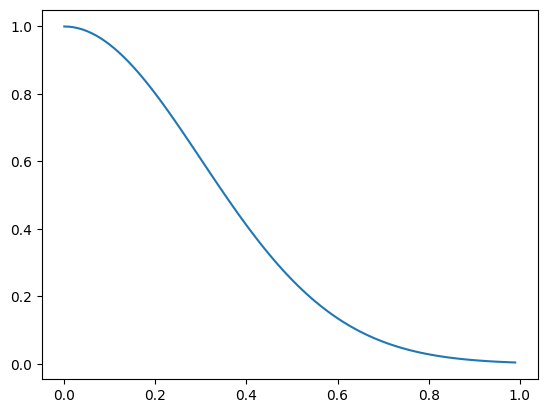

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i / 100 for i in list(range(100))], [score(i / 100) for i in range(100)])

In [ ]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 5e-7,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "constant",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 8, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 1024,
    num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = -1,
    save_steps = 10000,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "./grpo_ckpts",
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[smoother_accuracy, format_reward_func, length_penalty],
    args=training_args,
    train_dataset=rl_data,
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 8


In [ ]:
# quick sanity check we see the same generation/cot traces that we did during SFT
from vllm import SamplingParams
from vllm.lora.request import LoRARequest

trainer.llm.generate(["What is the total market size for commercial lithographic printing in the US?<think>"], SamplingParams(temperature=0, max_tokens=1024), lora_request=trainer.model.load_lora('grpo_trainer_lora_model', load_tensors=True))[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 7.41 toks/s, output: 72.25 toks/s]


'\nWe start by noting that the US commercial printing market is estimated to be on the order of several hundred billion dollars annually. A common rough estimate is that the overall US printing market (including both commercial and personal/home printing) is around 100 billion dollars, with commercial printing (which includes lithography, offset, digital, and other large-scale printing services) representing roughly 60% of that. This gives a commercial market size of about 60 billion dollars. Within commercial printing, lithography is a niche segment that is often estimated to be around 10–15% of the total commercial printing spend. Taking a midpoint of 12–13%, we arrive at a range of roughly 7–8 billion dollars. For our final answer we choose a single number in the middle of that range.\n</think>\n<answer>7.5</answer><|end|>'

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,285 | Num Epochs = 1 | Total steps = 1,285
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 69,206,016/2,078,346,240 (3.33% trained)


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / smoother_accuracy,rewards / format_reward_func,rewards / length_penalty
1,0.032700,0.000563,0.031802,371.375000,0.818062,0.015201,0.000000,-0.014638
2,0.035600,0.074019,0.168212,289.750000,0.888987,0.084490,0.000000,-0.010471
3,0.025800,-0.000587,0.017484,468.875000,0.644308,0.014091,0.000000,-0.014679
4,0.029800,-0.007630,0.005801,380.000000,0.746234,0.005818,0.000000,-0.013448
5,0.028400,0.281162,0.571529,325.625000,0.710602,0.294103,0.000000,-0.012941
6,0.024600,-0.014362,0.004729,393.000000,0.613830,0.000000,0.000000,-0.014362
7,0.033800,0.016575,0.046078,297.375000,0.844057,0.028054,0.000000,-0.011479
8,0.026200,-0.012978,0.002052,336.375000,0.654045,0.000000,0.000000,-0.012978
9,0.027300,0.201738,0.606185,374.500000,0.682731,0.214219,0.000000,-0.012481
10,0.026900,0.025734,0.058570,416.750000,0.672889,0.040358,0.000000,-0.014624


Unsloth: Will smartly offload gradients to save VRAM!
could not convert string to float: '1.52.0'


TrainOutput(global_step=1285, training_loss=2.865896757906629, metrics={'train_runtime': 23863.0358, 'train_samples_per_second': 0.054, 'train_steps_per_second': 0.054, 'total_flos': 0.0, 'train_loss': 2.865896757906629})

In [ ]:
path_specifier = "2smooth0.3-lr5e-7-augmented-sft-ckpt--rewards-phi-3.5-mini-instruct"

In [ ]:
model.save_pretrained(f"/content/drive/MyDrive/cs234/unsloth_sft_ckpts/rl_loras/{path_specifier}") # Local saving

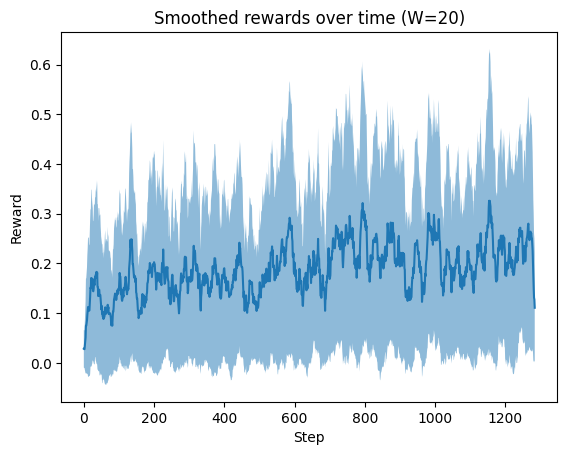

In [ ]:
import matplotlib.pyplot as plt
import json

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

reward_metrics = [entry['reward'] for entry in trainer.state.log_history if 'reward' in entry]
reward_std_metrics = [entry['reward_std'] for entry in trainer.state.log_history if 'reward_std' in entry]

n_samples = 4
errors = [std / np.sqrt(n_samples) for std in reward_std_metrics]

window_size = 20
smoothed_rewards = moving_average(reward_metrics, window_size)
smoothed_stds = moving_average(reward_std_metrics, window_size)
smoothed_errors = moving_average(errors, window_size)
smoothed_lb = [val - err for val, err in zip(smoothed_rewards, smoothed_errors)]
smoothed_ub = [val + err for val, err in zip(smoothed_rewards, smoothed_errors)]

plt.plot(range(len(rl_data)), smoothed_rewards)
plt.fill_between(range(len(rl_data)), smoothed_lb, smoothed_ub, alpha=0.5)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Smoothed rewards over time (W={window_size})")

plt.savefig(f"/content/drive/MyDrive/cs234/{path_specifier}_smoothed_rewards.png")

with open(f"/content/drive/MyDrive/cs234/{path_specifier}_metrics.json", "w") as f:
  json.dump({
      "rewards": reward_metrics,
      "stds": reward_std_metrics,
  }, f)

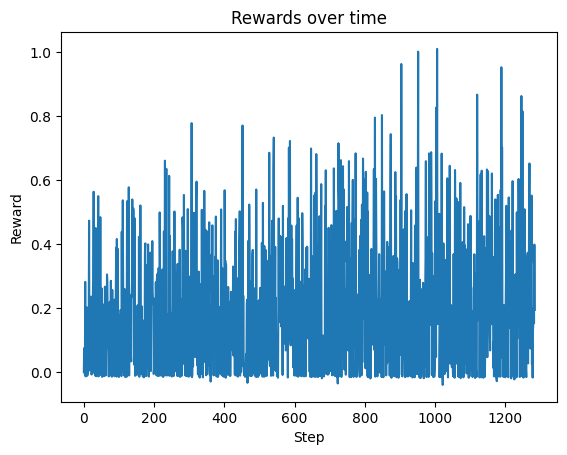

In [ ]:
plt.clf()
plt.plot(range(len(rl_data)), reward_metrics)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Rewards over time")
plt.savefig(f"/content/drive/MyDrive/cs234/{path_specifier}_rewards.png")

In [17]:
# import shutil

# shutil.copytree("./grpo_ckpts", f"/content/drive/MyDrive/cs234/unsloth_rl_ckpts/{path_specifier}")

'/content/drive/MyDrive/cs234/unsloth_rl_ckpts/2smooth0.3-lr5e-7-augmented-sft-ckpt--rewards-phi-3.5-mini-instruct'

In [ ]:
import unsloth

from unsloth import FastLanguageModel, FastLlamaModel, is_bfloat16_supported
from peft import PeftModel, LoraConfig

import torch
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name="unsloth/Phi-3.5-mini-instruct",
    model_name = "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/augmented-sft-phi-3.5-mini-instruct/checkpoint-1991",
    # model_name = "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

# model.save_pretrained_merged("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/augmented-sft-phi-3.5-mini-instruct/merged-ckpt", tokenizer, save_method = "merged_4bit_forced", safe_serialization=None)

# model = PeftModel.from_pretrained(model, "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct")

# lora_config = LoraConfig.from_pretrained("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct")
# model.load_adapter("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct", "default");

# model = FastLlamaModel.patch_peft_model(model, False)

# model = FastLanguageModel.get_peft_model(
#     model,
#     r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
#     target_modules = ["gate_proj", "up_proj", "down_proj",],
# )

# model.load_lora("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct");

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-13 09:51:24 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 24.67 GB

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-13 09:51:41 model_runner.py:1115] Loading model weights took 2.1371 GB
INFO 03-13 09:51:41 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 09:51:44 worker.py:267] Memory profiling takes 2.58 seconds
INFO 03-13 09:51:44 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 03-13 09:51:44 worker.py:267] model weights take 2.14GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.38GiB; the rest of the memory reserved for KV Cache is 24.77GiB.
INFO 03-13 09:51:44 executor_base.py:111] # cuda blocks: 4226, # CPU blocks: 1024
INFO 03-13 09:51:44 executor_base.py:116] Maximum concurrency for 512 tokens per request: 132.06x
INFO 03-13 09:51:49 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:55<00:00,  1.30s/it]

INFO 03-13 09:52:44 model_runner.py:1562] Graph capturing finished in 56 secs, took 1.09 GiB
INFO 03-13 09:52:44 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 63.61 seconds



Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


In [ ]:
model.peft_config

{'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='unsloth/phi-3.5-mini-instruct-bnb-4bit', revision=None, inference_mode=False, r=64, target_modules={'down_proj', 'gate_proj', 'up_proj'}, exclude_modules=None, lora_alpha=64, lora_dropout=0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, eva_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}

In [ ]:
model.active_adapters

['default']

In [ ]:
merged_model = model.merge_and_unload()

RuntimeError: The size of tensor a (12582912) must match the size of tensor b (8192) at non-singleton dimension 0

In [ ]:
# model.load_adapter("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct", "default");

In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (k_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (v_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=3072, out_features=8192, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
              

In [ ]:
merged_model = model.merge_and_unload()

RuntimeError: The size of tensor a (12582912) must match the size of tensor b (8192) at non-singleton dimension 0

In [ ]:
import os, gc, functools, types
from transformers import set_seed as transformers_set_seed
from unsloth.models._utils import patch_unsloth_smart_gradient_checkpointing, offload_input_embeddings, offload_output_embeddings, __version__
from unsloth.models.llama import unsloth_fast_generate
from peft import PeftModelForCausalLM, TaskType, get_peft_model as _get_peft_model
import inspect
from transformers.models.llama.modeling_llama import logger


def get_peft_model(
    model,
    r                   = 16,
    target_modules      = ["q_proj", "k_proj", "v_proj", "o_proj",
                       "gate_proj", "up_proj", "down_proj"],
    lora_alpha          = 16,
    lora_dropout        = 0,
    bias                = "none",
    layers_to_transform = None,
    layers_pattern      = None,
    use_gradient_checkpointing = True,
    random_state        = 3407,
    max_seq_length      = 2048, # not used anymore
    use_rslora          = False,
    modules_to_save     = None,
    init_lora_weights   = True,
    loftq_config        = {},
    temporary_location  = "_unsloth_temporary_saved_buffers",
    lora_path           = None,
    **kwargs,
):
    if os.environ.get("UNSLOTH_ENABLE_FULL_FINETUNING", "0") == "1":
        print("Unsloth: Full finetuning is enabled, so .get_peft_model has no effect")
        return model
    pass
    transformers_set_seed(random_state)
    if use_gradient_checkpointing == "unsloth":
        patch_unsloth_smart_gradient_checkpointing(dtype = model.get_input_embeddings().weight.dtype)

    if loftq_config is None: loftq_config = {}
    signature = str(inspect.signature(LoraConfig))
    SUPPORTS_LOFTQ  = "loftq_config" in signature
    SUPPORTS_RSLORA = "use_rslora"   in signature
    if lora_dropout != 0:
        logger.warning_once(
            f"Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = {lora_dropout}.\n"\
            f"Unsloth will patch all other layers, except LoRA matrices, causing a performance hit."
        )
    pass
    if bias != "none":
        logger.warning_once(
            f"Unsloth: bias = `none` is supported for fast patching. You are using bias = {bias}.\n"\
            f"Unsloth will patch all other layers, except LoRA matrices, causing a performance hit."
        )
    pass
    if not (type(init_lora_weights) is bool or \
        init_lora_weights == "gaussian" or init_lora_weights == "loftq"):
        raise ValueError(
            'Unsloth: `init_lora_weights` must be either [True, False, "gaussian", "loftq"].'
        )
    pass
    if init_lora_weights == "loftq":
        if not SUPPORTS_LOFTQ:
            import peft
            raise RuntimeError(
                f"Unsloth: Your PEFT version of {peft.__version__} does not support LoftQ init.\n"\
                "Please install PEFT 0.7.2 or higher.\n"\
                "You can also install from source: `pip install git+https://github.com/huggingface/peft.git"
            )
        pass
        if loftq_config == {}:
            from peft import LoftQConfig
            logger.warning_once(
                "Unsloth: init_lora_weights = `loftq` is set, but `loftq_config` is None.\n"\
                "We shall use `loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1)`."
            )
            loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1)
        pass

        if hasattr(model.config, "quantization_config"):
            raise ValueError(
                "Unsloth: You are using `loftq` init, yet `load_in_4bit = True` was set.\n"\
                "Reload your model without any quantization by setting `load_in_4bit = False`."
            )
        pass
    pass
    assert(type(use_rslora) is bool)
    if use_rslora:
        if not SUPPORTS_RSLORA:
            # We manually check for PEFT
            import peft
            raise RuntimeError(
                f"Unsloth: Your PEFT version of {peft.__version__} does not support `use_rslora`.\n"\
                "Please install PEFT 0.7.2 or higher.\n"\
                "You can also install from source: `pip install git+https://github.com/huggingface/peft.git"
            )
        pass
    pass
    accepted_modules = frozenset(("q_proj", "k_proj", "v_proj", "o_proj",
                                  "gate_proj", "up_proj", "down_proj",),)
    model.config.update({"unsloth_version" : __version__})
    if type(modules_to_save) is tuple:
        modules_to_save = list(modules_to_save)
    pass
    train_lm_head = False
    train_embed_tokens = False
    final_modules = []
    for module in target_modules:
        if module == "lm_head":
            # logger.warning_once(
            #     "Unsloth: `lm_head` should be placed in `modules_to_save` and not `target_modules`. "\
            #     "Luckily, we shall do it for you!"
            # )
            train_lm_head = True
            if modules_to_save is None: modules_to_save = ["lm_head"]
            else: modules_to_save.append("lm_head")
        elif module == "embed_tokens":
            # logger.warning_once(
            #     "Unsloth: `embed_tokens` should be placed in `modules_to_save` and not `target_modules`. "\
            #     "Luckily, we shall do it for you!"
            # )
            train_embed_tokens = True
            if modules_to_save is None: modules_to_save = ["embed_tokens"]
            else: modules_to_save.append("embed_tokens")
        else:
            try:
                assert(module in accepted_modules)
                final_modules.append(module)
            except AssertionError as e:
                final_modules.append(module)
                print(
                    "Unsloth: You added custom modules, but Unsloth hasn't optimized for this.\n"\
                    "Beware - your finetuning might be noticeably slower!"
                )
            pass
        pass
    pass
    # Check if we added new tokens!
    if hasattr(model, "_need_to_train_embeddings"):
        if not train_lm_head or not train_embed_tokens:
            print(
                "Unsloth: You added new tokens but did not specify if you wanted to "\
                "train the lm_head and embed_tokens.\nWe must turn it on for you."
            )
            train_lm_head = True
            train_embed_tokens = True
            if modules_to_save is None: modules_to_save = ["embed_tokens"]
            else: modules_to_save.append("embed_tokens")
            if modules_to_save is None: modules_to_save = ["lm_head"]
            else: modules_to_save.append("lm_head")
        pass
    pass
    # Check for Llama-3
    # if hasattr(model._saved_temp_tokenizer, "_using_llama3_template"):
    #     if not train_embed_tokens and not train_lm_head:
    #         raise RuntimeError("")
    # First fix untrained tokens
    # Wrong - can cause reserved tokens to pop out!!
    # if train_embed_tokens or train_lm_head:
    #     fix_untrained_tokens(model, eps = 1e-16)
    # pass
    # Check modules_to_save
    if modules_to_save is not None:
        for module in modules_to_save:
            if module == "lm_head":
                train_lm_head = True
            elif module == "embed_tokens":
                train_embed_tokens = True
            else:
                raise TypeError(
                    f"Unsloth: Module = {module} is not allowed. Only 'lm_head' and 'embed_tokens' is allowed."
                )
        pass
    pass
    if isinstance(modules_to_save, (tuple, list)):
        modules_to_save = list(set(modules_to_save))
    pass
    vllm_engine = None
    if hasattr(model, "vllm_engine"):
        # Fast inference!
        vllm_engine = model.vllm_engine
        vllm_fast_generate = model.fast_generate
        vllm_fast_generate_batches = model.fast_generate_batches
        if modules_to_save is not None:
            raise NotImplementedError("Unsloth: Currently fast inference does not work with training embeddings or lm_head.")
        if bias != "none":
            raise NotImplementedError("Unsloth: Currently fast inference does not work with using biases for LoRA.")
    pass
    # Get LoRA
    arguments = dict(
        r                   = r,
        lora_alpha          = lora_alpha,
        target_modules      = final_modules,
        lora_dropout        = lora_dropout,
        bias                = bias,
        task_type           = TaskType.CAUSAL_LM,
        layers_to_transform = layers_to_transform,
        init_lora_weights   = init_lora_weights,
        loftq_config        = loftq_config,
        use_rslora          = use_rslora,
        modules_to_save     = modules_to_save,
        **kwargs,
    )
    if not SUPPORTS_LOFTQ:  del arguments["loftq_config"]
    if not SUPPORTS_RSLORA: del arguments["use_rslora"]
    _saved_temp_tokenizer = model._saved_temp_tokenizer
    lora_config = LoraConfig(**arguments)
    # First offload lm_head and embed_tokens to disk
    input_embeddings_device  = model. get_input_embeddings().weight.device
    output_embeddings_device = model.get_output_embeddings().weight.device
    if use_gradient_checkpointing == "unsloth":
        if train_embed_tokens:
            print("Unsloth: Offloading input_embeddings to disk to save VRAM")
            offload_input_embeddings(model, temporary_location)
        pass
        # Remove old items to save VRAM
        for _ in range(3):
            gc.collect()
            torch.cuda.empty_cache()
        pass
        if train_lm_head:
            print("Unsloth: Offloading output_embeddings to disk to save VRAM")
            offload_output_embeddings(model, temporary_location)
        pass
        # Remove old items to save VRAM
        for _ in range(3):
            gc.collect()
            torch.cuda.empty_cache()
        pass
    pass

    # model = _get_peft_model(model, lora_config)
    # model = PeftModel.from_pretrained(model, lora_path)
    model._saved_temp_tokenizer = _saved_temp_tokenizer
    # model = FastLlamaModel.patch_peft_model(model, use_gradient_checkpointing)
    if train_embed_tokens:
        print("Unsloth: Training embed_tokens in mixed precision to save VRAM")
        assert(hasattr(model.get_input_embeddings(), "modules_to_save"))
        new_dtype = model.get_input_embeddings().modules_to_save.default.weight.dtype
        if new_dtype == torch.float16:
            # See https://github.com/unslothai/unsloth/pull/1200
            # Tesla T4 must use float32 and not float16
            new_dtype = torch.float32
        pass
        model.get_input_embeddings().modules_to_save.default\
            .to(device = "cuda", dtype = new_dtype, non_blocking = True)
        model.get_input_embeddings().modules_to_save.default.requires_grad_(True)
    pass
    if train_lm_head:
        print("Unsloth: Training lm_head in mixed precision to save VRAM")
        assert(hasattr(model.get_output_embeddings(), "modules_to_save"))
        new_dtype = model.get_output_embeddings().modules_to_save.default.weight.dtype
        if new_dtype == torch.float16:
            # See https://github.com/unslothai/unsloth/pull/1200
            # Tesla T4 must use float32 and not float16
            new_dtype = torch.float32
        pass
        model.get_output_embeddings().modules_to_save.default\
            .to(device = "cuda", dtype = new_dtype, non_blocking = True)
        model.get_output_embeddings().modules_to_save.default.requires_grad_(True)
    pass
    # Patch tokenizer to pad to the right
    internal_model = model
    while hasattr(internal_model, "model"):
        if hasattr(internal_model, "_saved_temp_tokenizer"):
            internal_model._saved_temp_tokenizer.padding_side = "right"
        pass
        # Also set is_loaded_in_8bit to disable incorrect DDP
        internal_model.is_loaded_in_8bit = True
        internal_model = internal_model.model
    pass
    if hasattr(internal_model, "_saved_temp_tokenizer"):
        internal_model._saved_temp_tokenizer.padding_side = "right"
    pass
    # Also set is_loaded_in_8bit to disable incorrect DDP
    internal_model.is_loaded_in_8bit = True
    # Clear deleted GPU items
    for _ in range(3):
        gc.collect()
        torch.cuda.empty_cache()
    pass
    # Patch for fast inference
    if vllm_engine is not None:
        model.vllm_engine = vllm_engine
        model.fast_generate = vllm_fast_generate
        model.fast_generate_batches = vllm_fast_generate_batches
        # Also saving and loading LoRA
        from unsloth_zoo.vllm_utils import save_lora, load_lora
        model.save_lora = functools.partial(save_lora, model)
        model.load_lora = functools.partial(load_lora, model)
    pass
    # Add for_inference and for_training
    model.for_training  = functools.partial(FastLlamaModel.for_training,  model)
    model.for_inference = functools.partial(FastLlamaModel.for_inference, model)
    # Patch generate
    if model.generate.__name__ != "unsloth_fast_generate":
        model._old_generate = model.generate
        unsloth_fast_generate.__doc__ = model._old_generate.__doc__
        model.generate = types.MethodType(unsloth_fast_generate, model)
    return model
pass

In [ ]:
model = get_peft_model(model,
                       r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
                       target_modules = ["gate_proj", "up_proj", "down_proj",])

In [ ]:
# model = FastLlamaModel.patch_peft_model(peft_model, False)

Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


In [ ]:
# model.load_adapter("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct", "default");

In [ ]:
model.peft_config

{'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='unsloth/phi-3.5-mini-instruct-bnb-4bit', revision=None, inference_mode=True, r=64, target_modules={'gate_proj', 'down_proj', 'up_proj'}, exclude_modules=None, lora_alpha=16, lora_dropout=0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, eva_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}

In [ ]:
# [(n, m) for n, m in model.named_modules() if "lora" in n.lower()]
weight_before_load = model.base_model.model.model.layers[1].mlp.gate_proj.lora_A['default'].weight.clone()

In [ ]:
model.load_lora("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct");

In [ ]:
weight_before_load == model.base_model.model.model.layers[1].mlp.gate_proj.lora_A['default'].weight

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
model.adapters

AttributeError: 'LlamaForCausalLM' object has no attribute 'adapters'

In [ ]:
from peft import PeftModel

model = PeftModel.from_pretrained(model, "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct")

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.mlp.up_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.mlp.down_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.mlp.down_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.1.mlp.gate_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.1.mlp.gate_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.1.mlp.up_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.1.mlp.up_proj.lora_B.default.we

In [ ]:
from datasets import Dataset

SYSTEM_PROMPT = """
You are an expert assistant at estimating market size, TAM, and other relevant statistics. We will interpret your answer as being in {unit}.
Respond in the following format:
<think>
...
</think>
<answer>
...
</answer>
"""

def transform(row):
  return {
      "prompt": [
          {"role": "system", "content": SYSTEM_PROMPT.format(unit=row["Unit"])},
          {"role": "user", "content": row['Prompt']}
      ],
      "ground_truth": row["Value"]
  }


rl_data = Dataset.from_pandas(raw_rl_data).map(transform).remove_columns(["Prompt", "Unit", "Value", "Source"])

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

In [ ]:
# from trl import apply_chat_template

# rl_data = rl_data.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer}, num_proc=10, remove_columns=['prompt'])\
#                  .map(lambda row: {"prompt": [row["prompt"]], "ground_truth": row["ground_truth"]})  # prompt as list

In [ ]:
rl_data[400]

{'prompt': [{'content': '\nYou are an expert assistant at estimating market size, TAM, and other relevant statistics. We will interpret your answer as being in number of people.\nRespond in the following format:\n<think>\n...\n</think>\n<answer>\n...\n</answer>\n',
   'role': 'system'},
  {'content': 'How many people are employed in the remodeling industry in Maryland?',
   'role': 'user'}],
 'ground_truth': 30213.0}

In [ ]:
# max_length = max([len(tokenizer.encode(row[0]['content'])) + len(tokenizer.encode(row[1]['content'])) for row in rl_data['prompt']])
# max_length

In [ ]:
import numpy as np
import re

def accuracy_reward(completions, ground_truth, **kwargs):
  rewards = []
  for message_obj, gt in zip(completions, ground_truth):
    completion = message_obj[0]['content']
    match_obj = re.match(r"[\s\S]*<answer>(.*?)</answer>.*", completion)
    if match_obj is not None:
      raw_answer = match_obj.group(1)
      try:
        extracted_answer = float(re.sub(r"[^\d\.]", "", raw_answer))
        rewards.append(
            float((abs(extracted_answer - float(gt)) / float(gt)) <= 0.05)
        )
      except:
        rewards.append(0.0)
    else:
        rewards.append(0.0)
  return rewards


def score(x):
    # Approx. equal to 1 at |x|=0
    # Approx. equal to 0 at |x|=1
    # Assign higher reward as we get closer to |x|=0
    # R(0.5) = 0.04, R(0.25) = 0.46, R(0.1) = 0.88, ...
    # return 1 / np.sqrt(2 * np.pi * 0.1592) * np.exp(-0.5 * (x / 0.2) ** 2)
    return 1 / np.sqrt(2 * np.pi * 0.1592) * np.exp(-0.5 * (x / 0.3) ** 2)


def smoother_accuracy(completions, ground_truth, **kwargs):
  rewards = []
  for message_obj, gt in zip(completions, ground_truth):
    completion = message_obj[0]['content']
    print(completion)
    match_obj = re.match(r"[\s\S]*<answer>(.*?)</answer>.*", completion)
    if match_obj is not None:
      raw_answer = match_obj.group(1)
      try:
        extracted_answer = float(re.sub(r"[^\d\.]", "", raw_answer))
        rewards.append(
            2 * score(float(abs(extracted_answer - float(gt))) / float(gt))
        )
      except Exception as e:
        print(e)
        rewards.append(0.0)
    else:
        rewards.append(0.0)
  return rewards


def format_reward_func(completions, ground_truth, **kwargs):
  total = 0
  pattern = r"^[\s]*<think>.*?</think>[\s]*<answer>.*?</answer>[\s]*$"
  at_least_once = [1 if re.match(pattern, completion[0]['content'], re.S) else 0 for completion in completions]
  exactly_once = [1 if len(re.findall("<think>", completion[0]['content'], re.S)) > 1 else 0 for completion in completions]
  return [((gte1 + eq1) - 1) / 5 for gte1, eq1 in zip(at_least_once, exactly_once)]


def length_penalty(completions, ground_truth, **kwargs):
  return [-len(cmpl[0]['content']) / 105400 for cmpl in completions]

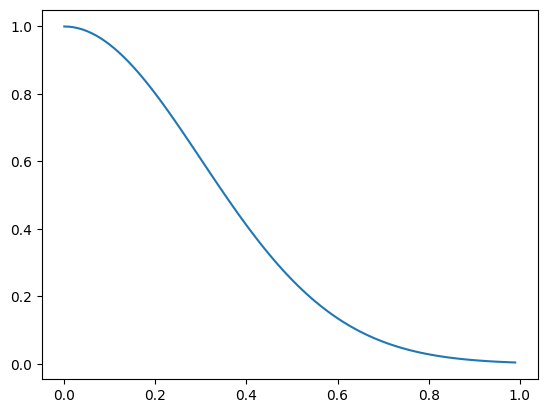

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i / 100 for i in list(range(100))], [score(i / 100) for i in range(100)])

In [ ]:
from vllm import SamplingParams
from trl import GRPOTrainer
from vllm.lora.request import LoRARequest

# from unsloth.models.llama import *

# peftm = FastLanguageModel.get_peft_model(
#     model,
#     r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
#     target_modules = ["gate_proj", "up_proj", "down_proj",],
# )

# peftm.load_lora("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/augmented-sft-phi-3.5-mini-instruct");

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[smoother_accuracy, format_reward_func, length_penalty],
    args=training_args,
    train_dataset=rl_data,
)

trainer.llm.generate(["What is the total market size for commercial lithographic printing in the US?<think>"], SamplingParams(temperature=0, max_tokens=1024), lora_request=trainer.model.load_lora('grpo_trainer_lora_model', load_tensors=True)) # LoRARequest("sft-ckpt", 1, peftm))

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 7.36 toks/s, output: 73.94 toks/s]


[RequestOutput(request_id=1, prompt='What is the total market size for commercial lithographic printing in the US?<think>', prompt_token_ids=[1724, 338, 278, 3001, 9999, 2159, 363, 12128, 301, 389, 12122, 14010, 297, 278, 3148, 29973, 29966, 386, 682, 29958], encoder_prompt=None, encoder_prompt_token_ids=None, prompt_logprobs=None, outputs=[CompletionOutput(index=0, text='\nWe start by noting that the US commercial printing market is estimated to be on the order of several hundred billion dollars annually. A common rough estimate is that the overall US printing market (including both commercial and personal printing) is around 100 billion dollars. Lithography, which is a high‐end printing process used for large-scale, high‐quality print runs, is a niche within that broader market. Based on industry reports and market segmentation, commercial lithographic printing (for large projects such as billboards, posters, and other high‐volume, high‐value print jobs) typically accounts for roughl

In [ ]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 1e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "constant",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 1024,
    num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = -1,
    save_steps = 10000,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "./grpo_ckpts",
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[smoother_accuracy, format_reward_func, length_penalty],
    args=training_args,
    train_dataset=rl_data,
)
trainer.train()

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,285 | Num Epochs = 1 | Total steps = 1,285
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 69,206,016/2,078,346,240 (3.33% trained)


<think>
Estimating the total addressable market (TAM) for hardware in Florida is a challenging exercise due to the diversity of businesses involved and the regional market’s fragmented nature with both large national suppliers and myriad local, smaller companies providing a wide range of product segments. One approach is to aggregate the hardware manufacturing activity in several overlapping sectors—including commercial hardware (like security and control systems), construction, agricultural, coastal defense, and related infrastructure—and to make reasonable assumptions about their relative contributions. Florida’s large population and substantial economic activity in areas ranging from retirement communities and ecommerce hubs to fishing and agriculture, as well as its vulnerability to hurricanes and need for coastal and security gear, suggest a strong hardware manufacturing base. Based on industry surveys, construction and related commercial hardware might serve the majority of the d

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / smoother_accuracy,rewards / format_reward_func,rewards / length_penalty
1,0.031600,-0.009652,0.005497,333.000000,0.790511,0.003870,0.000000,-0.013522
2,0.039200,-0.001485,0.010033,283.750000,0.981076,0.008261,0.000000,-0.009746
3,3246.700400,-0.163510,0.101389,394.750000,81167.507812,0.000000,-0.150000,-0.013510
4,343.233500,-0.055985,0.105521,295.500000,8580.835938,0.003865,-0.050000,-0.009851
5,51319.566400,0.032840,0.242324,311.500000,1282989.250000,0.094272,-0.050000,-0.011433
6,13773.277300,-0.063079,0.101932,338.750000,344331.906250,0.000000,-0.050000,-0.013079
7,0.033500,0.104448,0.224380,317.750000,0.836817,0.116815,0.000000,-0.012367
8,7106.450200,-0.166670,0.100615,420.750000,177661.250000,0.000000,-0.150000,-0.016670
9,109.438100,-0.215401,0.001637,434.000000,2735.953613,0.000000,-0.200000,-0.015401
10,178.510700,-0.042752,0.118690,340.750000,4462.766113,0.020145,-0.050000,-0.012896


<think>
To provide an estimate for Minnesota’s home‐building market size, we first break down the total addressable market. Minnesota's total annual building permit issuance outlines the number of new residential construction projects. The state has roughly 2.5 million residents, of which roughly 75% are in urban areas where multipod units (in the “building material” sense) – i.e. new residential construction – are a significant factor. This leads to about 1.9 million households. Under the assumption that the typical new home in Minnesota costs around 200,000 USD to build, we multiply the 1.9 million households by about 200,000 USD, yielding an estimated market size of about 370 billion USD. This calculation considers the overall statewide building activity and the average price for a new residential home.
</think>
<answer>370000000000</answer>
<think>
Step 1: We begin by noting that “home building” generally refers to residential new construction and demand‐driven remodeling in Minnes

Unsloth: Input IDs of length 513 > the model's max sequence length of 512.
We shall truncate it ourselves. It's imperative if you correct this issue first.


<think>
Step 1: Estimate total meat and poultry production in Tennessee.
• Approximate total beef production: Taking into account that the US produces roughly 25 million tons of beef annually, and Tennessee’s share (as a relatively small cattle‐grazing state) is a fraction of that, we estimate Tennessee beef production at about 1% of US total (i.e. 250,000 tons).
• Estimate total cattle population: Estimating that Tennessee’s cattle might be roughly 1.5 million head, with a livable weight of roughly 600 kg on average, that gives about 900,000 tons of beef (1.5 million cattle × 600 kg ÷ 1000 = 900,000 tons). Scaling that to our roughly 1% estimation gives roughly 250,000 tons of beef.
• Estimate annual chicken production: With Tennessee ranking near the midpoint in chicken production and roughly 7.5% of the US chicken market, we use again 25 million tons as the US total. Tennessee’s share would be 7.5% of that, i.e. 18.75 million tons.
• Poultry exports: Tennessee exports a modest porti

KeyboardInterrupt: 

In [ ]:
# path_specifier = "2smooth0.3-lr1e-6--rewards-synth-only-sft-phi-3.5-mini-instruct"

In [ ]:
model.save_pretrained(f"/content/drive/MyDrive/cs234/unsloth_sft_ckpts/rl_loras/{path_specifier}") # Local saving

In [ ]:
import matplotlib.pyplot as plt
import json

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

reward_metrics = [entry['reward'] for entry in trainer.state.log_history if 'reward' in entry]
reward_std_metrics = [entry['reward_std'] for entry in trainer.state.log_history if 'reward_std' in entry]

n_samples = 4
errors = [std / np.sqrt(n_samples) for std in reward_std_metrics]

window_size = 20
smoothed_rewards = moving_average(reward_metrics, window_size)
smoothed_stds = moving_average(reward_std_metrics, window_size)
smoothed_errors = moving_average(errors, window_size)
smoothed_lb = [val - err for val, err in zip(smoothed_rewards, smoothed_errors)]
smoothed_ub = [val + err for val, err in zip(smoothed_rewards, smoothed_errors)]

plt.plot(range(len(rl_data)), smoothed_rewards)
plt.fill_between(range(len(rl_data)), smoothed_lb, smoothed_ub, alpha=0.5)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Smoothed rewards over time (W={window_size})")

plt.savefig(f"/content/drive/MyDrive/cs234/{path_specifier}_smoothed_rewards.png")

with open(f"/content/drive/MyDrive/cs234/{path_specifier}_metrics.json", "w") as f:
  json.dump({
      "rewards": reward_metrics,
      "stds": reward_std_metrics,
  }, f)

In [ ]:
plt.clf()
plt.plot(range(len(rl_data)), reward_metrics)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Rewards over time")
plt.savefig(f"/content/drive/MyDrive/cs234/{path_specifier}_rewards.png")

In [ ]:
1 +1

2